In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
from scipy.stats import spearmanr, shapiro

In [108]:
df = pd.read_excel('../Dataset/simulation_data.xlsx')
df = df.iloc[:29]
first_row_values = df.iloc[0]
df.columns = list(first_row_values[:5]) + list(df.columns[5:])
df = df.iloc[2:, 1:]
df.drop(columns=['Zielwerte', 'Innoculum MiBi', 'Ablagerung \nRang', 'Prozess-\nparameter'], inplace=True)
df.set_index('Waschen', inplace=True)

df

,Temperatur,Konzentration des Desinfektionsmittels,Zeit,timestamp,oberflaechenspannung,uvenergie_mean,uvenergie_std,uvenergie_median,uvenergie_percentile25,uvenergie_percentile75,...,abs210_median,abs210_percentile25,abs210_percentile75,GH/KH_mean,GH/KH_std,GH/KH_median,GH/KH_percentile25,GH/KH_percentile75,Red KBE Mikrobiologie \n[log 10 KBE Reduziert],Energieverbrauch \n(ausgehend von Favorit plus nach Norm in kWh)
Waschen,,,,,,,,,,,,,,,,,,,,,
1,55,3,5,1.634027e+09,66.8,NaN,NaN,NaN,NaN,NaN,...,1.449664,1.448954,1.453887,0.0,0.00,1.0,1.0,2.0,6.130,0.30
2,55,1.6,60,1.634027e+09,66.2,NaN,NaN,NaN,NaN,NaN,...,0.191582,0.189564,0.193199,2.0,0.02,3.0,3.0,4.0,3.950,3.30
3,55,3,32.5,1.634027e+09,66.5,NaN,NaN,NaN,NaN,NaN,...,1.515012,1.507145,1.520853,4.0,0.04,5.0,5.0,6.0,6.330,1.50
4,40,2,5,1.634027e+09,69.1,NaN,NaN,NaN,NaN,NaN,...,0.251245,0.249950,0.253152,3.0,0.03,4.0,4.0,5.0,4.830,0.20
5,70,2,60,1.634651e+09,62.8,NaN,NaN,NaN,NaN,NaN,...,1.212803,1.210740,1.214665,0.0,0.00,1.0,1.0,2.0,5.197,4.80
6,70,3,32.5,1.634651e+09,63.1,NaN,NaN,NaN,NaN,NaN,...,1.662854,1.658027,1.670294,4.0,0.04,5.0,5.0,6.0,6.630,2.50
7,70,3,60,1.634824e+09,62.1,NaN,NaN,NaN,NaN,NaN,...,1.890761,1.887111,1.895173,3.0,0.03,4.0,4.0,5.0,7.030,4.80
8,40,2,32.5,1.634824e+09,68.7,NaN,NaN,NaN,NaN,NaN,...,2.065746,2.049112,2.074076,3.0,0.03,4.0,4.0,5.0,4.630,1.10
9,40,2,60,1.635338e+09,68.3,NaN,NaN,NaN,NaN,NaN,...,0.736664,0.734820,0.739086,1.0,0.01,2.0,2.0,3.0,4.470,2.50


In [109]:
df.columns

Index(['Temperatur', 'Konzentration des Desinfektionsmittels ', 'Zeit',
       'timestamp', 'oberflaechenspannung', 'uvenergie_mean', 'uvenergie_std',
       'uvenergie_median', 'uvenergie_percentile25', 'uvenergie_percentile75',
       ...
       'abs210_median', 'abs210_percentile25', 'abs210_percentile75',
       'GH/KH_mean', 'GH/KH_std', 'GH/KH_median', 'GH/KH_percentile25',
       'GH/KH_percentile75', 'Red KBE Mikrobiologie \n[log 10 KBE Reduziert]',
       'Energieverbrauch \n(ausgehend von Favorit plus nach Norm in kWh)'],
      dtype='object', length=102)

In [121]:
doe_analysis_df = df.iloc[:, [0, 1, 2, 4, -1, -2]].astype(float)

In [122]:
doe_analysis_df

,Temperatur,Konzentration des Desinfektionsmittels,Zeit,oberflaechenspannung,Energieverbrauch \n(ausgehend von Favorit plus nach Norm in kWh),Red KBE Mikrobiologie \n[log 10 KBE Reduziert]
Waschen,,,,,,
1,55.0,3.0,5.0,66.8,0.30,6.130
2,55.0,1.6,60.0,66.2,3.30,3.950
3,55.0,3.0,32.5,66.5,1.50,6.330
4,40.0,2.0,5.0,69.1,0.20,4.830
5,70.0,2.0,60.0,62.8,4.80,5.197
6,70.0,3.0,32.5,63.1,2.50,6.630
7,70.0,3.0,60.0,62.1,4.80,7.030
8,40.0,2.0,32.5,68.7,1.10,4.630
9,40.0,2.0,60.0,68.3,2.50,4.470


<Axes: >

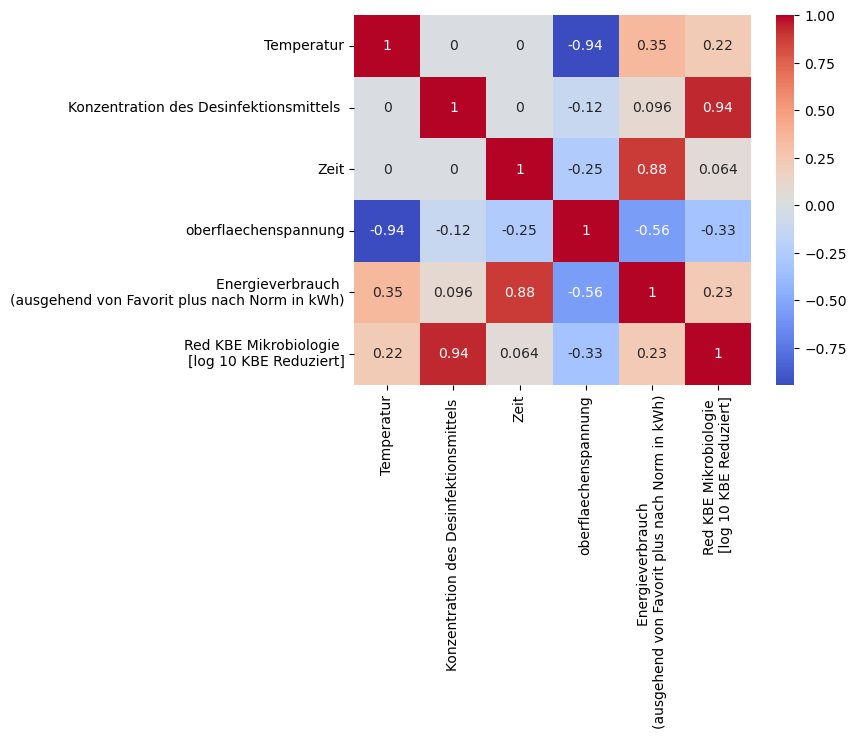

In [123]:
sns.heatmap(doe_analysis_df.corr(method='spearman'), cmap='coolwarm', annot=True)

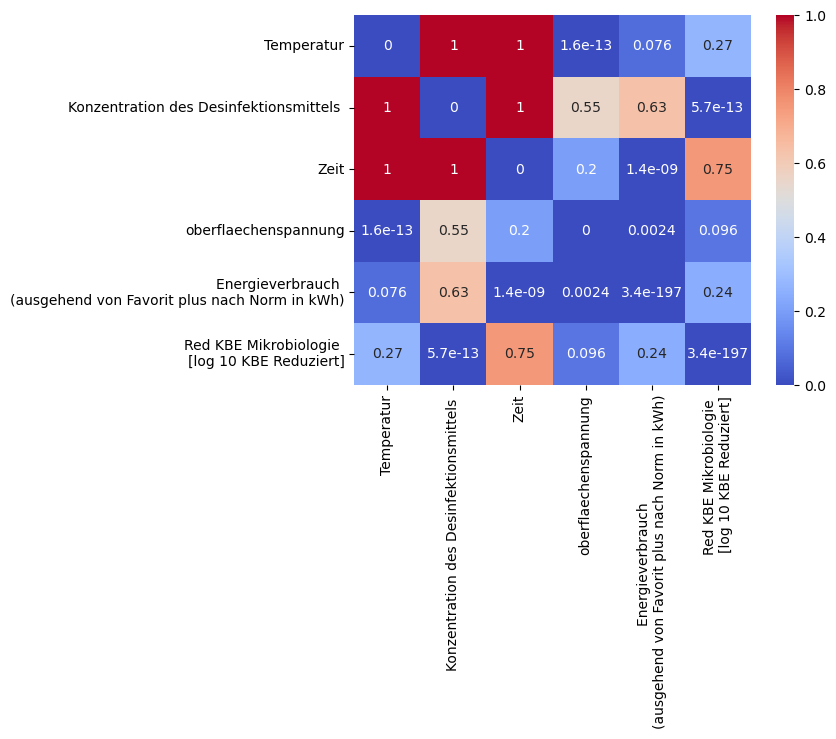

In [128]:
columns = doe_analysis_df.columns

p_values_df = pd.DataFrame(index=columns, columns=columns, dtype=float)
for col1 in columns:
    for col2 in columns:
        print()
        corr, p_value = spearmanr(doe_analysis_df[col1], doe_analysis_df[col2])
        p_values_df.loc[col1, col2] = p_value

sns.heatmap(p_values_df.astype(float), annot=True, cmap='coolwarm', vmin=0, vmax=1)

plt.show()

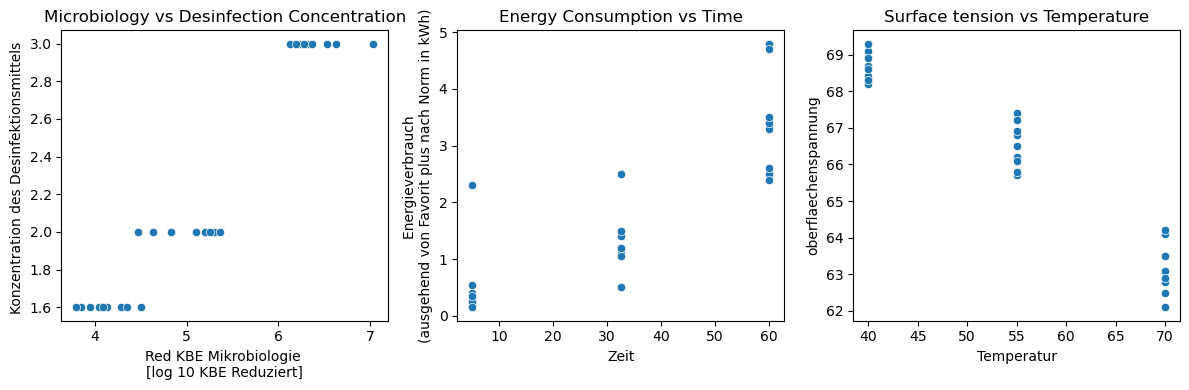

In [114]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
sns.scatterplot(data=doe_analysis_df, x=columns[-1], y=columns[1], ax=axes[0])
sns.scatterplot(data=doe_analysis_df, x=columns[2], y=columns[4], ax=axes[1])
sns.scatterplot(data=doe_analysis_df, x=columns[0], y=columns[3], ax=axes[2])
axes[0].set_title("Microbiology vs Desinfection Concentration")
axes[1].set_title("Energy Consumption vs Time")
axes[2].set_title("Surface tension vs Temperature")
plt.tight_layout()
plt.show()

/tmp/ipykernel_372/746739504.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(doe_analysis_df[columns[-1]], ax=axes[0])
/tmp/ipykernel_372/746739504.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(doe_analysis_df[columns[-2]], ax=axes[1])


Text(0.5, 1.0, 'SHAPIRO P_VALUE: 0.0099')

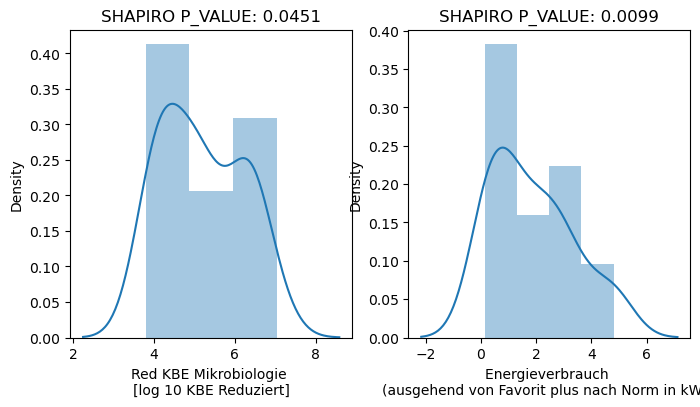

In [115]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
_, p_value1 = np.round(shapiro(doe_analysis_df[columns[-1]]), 4)
_, p_value2 = np.round(shapiro(doe_analysis_df[columns[-2]]), 4)
sns.distplot(doe_analysis_df[columns[-1]], ax=axes[0])
sns.distplot(doe_analysis_df[columns[-2]], ax=axes[1])
axes[0].set_title(f"SHAPIRO P_VALUE: {p_value1}")
axes[1].set_title(f"SHAPIRO P_VALUE: {p_value2}")